[-0.13131313  0.19191919  0.37373737  0.61616162] 0
[ 0.73737374 -0.47474747  0.21212121  0.47474747] 1
[0.53535354 0.97979798 0.55555556 0.77777778] 0
[ 0.57575758  0.5959596   0.45454545 -0.67676768] 5
[-0.43434343 -0.35353535  0.29292929 -0.45454545] 0
[-0.19191919  0.85858586  0.61616162 -0.5959596 ] 0
[-0.81818182 -0.55555556  0.11111111  0.01010101] 0
[-0.45454545 -0.97979798  0.19191919 -0.13131313] 0
[-0.93939394  0.65656566  0.63636364 -0.39393939] 0
[ 0.97979798 -0.31313131  0.5959596   0.07070707] 0
[ 1.         -0.19191919  0.93939394 -0.33333333] 0
[-0.5959596   0.5959596  -0.07070707  1.        ] 0
[-0.37373737 -0.39393939 -0.73737374  0.65656566] 0
[-0.55555556 -0.21212121  0.77777778  0.83838384] 1
[ 0.81818182 -0.49494949  0.11111111 -1.        ] 4
[-0.97979798  0.37373737  0.31313131  0.95959596] 0
[ 0.39393939 -0.25252525 -0.21212121  0.39393939] 0
[-0.05050505 -0.45454545  0.85858586 -0.35353535] 0
[ 0.13131313  0.91919192 -0.7979798   0.03030303] 4
[ 0.91919192  0.

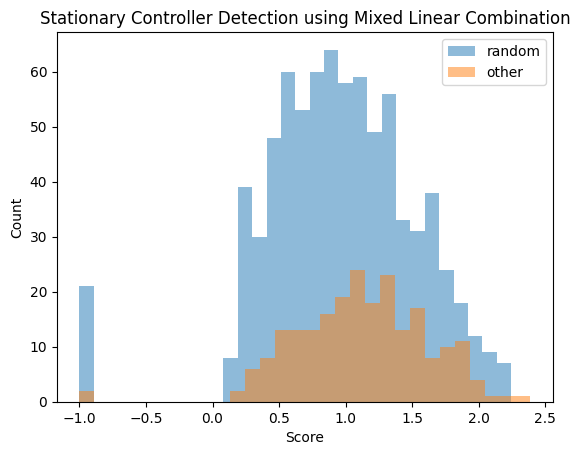

In [5]:
"""
A Script that plots the proportions of labeled class behaviors that fall within a certain magnitude.
The goal of this experiment is to determine if there is some more
"""

import torch
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import random
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import math

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

sampled_dataset = SwarmDataset("../data/full-mini", rank=0)
data = sampled_dataset

lim = 1000
controllers = []
classes = [-1 for i in range(lim)]
for i in range(lim):
    image, genome, behavior = sampled_dataset[i][0], sampled_dataset[i][1], sampled_dataset[i][2]
    for j in range(len(behavior)):
        if behavior[j] < 0.0:
            behavior[j] *= -1
    controllers.append(genome)

OUT = "../data/oracle"
with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        triplet = CSVLineToVec(line)
        classes[int(triplet[0])] = int(triplet[1])

random = []
not_random = []
for i, label in enumerate(classes):
    v0_l, v0_r = controllers[i][0], controllers[i][1]
    v1_l, v1_r = controllers[i][2], controllers[i][3]
    v0_l, v0_r, v1_l, v1_r = round(v0_l, 1), round(v0_r, 1), round(v1_l, 1), round(v1_r, 1)

    # Sensor off magnitude (trial i)
    on_magnitude = (v0_l**2) + (v0_r**2)

    # Sensor on magnitude (trial i)
    off_magnitude = (v1_l**2) + (v1_r**2)

    # Spinning Detection (sensor off - trial ii)
    if v0_l == 0.0 and v0_r == 0.0:
        off_spin_variance = 1
        print("Gottem")
    else:
        denom = v0_l if v0_l != 0.0 else v0_r
        off_spin_variance = min(abs((v0_l + v0_r) / denom), 1.0)
    # mx = off_spin_variance

    # Spinning Detection (sensor on - trial ii)
    if v1_l == 0.0 and v1_r == 0.0:
        on_spin_variance = 0.0
        print("Gottem")
    else:
        denom = v1_l if v1_l != 0.0 else v1_r
        on_spin_variance = min(abs((v1_l + v1_r) / denom), 1)
    # mx = on_spin_variance

    # Mirror Property
    mirrored_controller = np.array([v0_l, v0_r, -v0_l, -v0_r])
    mirror_score = np.linalg.norm(mirrored_controller - controllers[i])
    k_m = 0.15
    mirror_score = -1 if mirror_score < k_m else mirror_score
    mx = mirror_score

    # Mixed Stationary Score
    # mx = mirror_score + 2*on_spin_variance + 2*off_spin_variance + on_magnitude + off_magnitude

    # if mx == 0.0:
    #     print(controllers[i], classes[i])

    if mx < 4:
        print(controllers[i], classes[i])

    if label == 0:
        random.append(mx)
    else:
        not_random.append(mx)

plt.hist(random, bins=30, alpha=0.5, label='random')
plt.hist(not_random, bins=30, alpha=0.5, label='other')
plt.legend(loc='upper right')
plt.title("Stationary Controller Detection using Mixed Linear Combination")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# Also try hist2d with the second largest value from each controller

# EPSILON = 0.05
# total_counts = [0 for i in range(max(classes) + 1)]
# count = [0 for i in range(max(classes) + 1)]
# for i, vec in enumerate(controllers):
#     total_counts[classes[i]] += 1
#
#     nparr = np.array(vec)
#     # if np.linalg.norm(vec) > EPSILON:
#     #     count[classes[i]] += 1
#     for l in vec:
#         if EPSILON > l > -EPSILON:
#             print(vec)
#             count[classes[i]] += 1
#             break
#
# print(total_counts, count)

In [30]:
v0_l, v0_r, v1_l, v1_r = 2.0, -2.0, 2.0, -2.0

if v1_l == 0.0 and v1_r == 0.0:
    mx = 10
else:
    denom = v1_l if v1_l != 0.0 else v1_r
    mx = (v1_l + v1_r) / denom

print(mx)

0.0
